In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.units import Hartree, mol, kcal
from ase import Atoms
kcal_mol = kcal/mol
kcal_mol
Hart_to_kcalmol = Hartree/kcal_mol
#figp = '/home/awills/Documents/Research/figs/ml'

In [6]:
def read_eval_table_only(path):
    tab=pd.read_csv(path, delimiter='\t')
    return tab

def read_eval_table(path, epred = 2, eref = 3, aepred = 5, aeref = 6,
                   aerefmult = -1, scale=1, skipinds = None, mae=False):
    tab = pd.read_csv(path, delimiter = '\t').replace('nan', -100000)
    tab.columns = [i.strip() for i in tab.columns]
    tcol = tab.columns
    print(tab)
    aey = scale*tab[tcol[aepred]].astype(np.float64).values
    ey = scale*tab[tcol[epred]].astype(np.float64).values
    
    erefv = scale*tab[tcol[eref]].values
    aerefv = scale*tab[tcol[aeref]].values
    
    if skipinds:
        aey = np.array([aey[i] for i in range(len(aey)) if i not in skipinds])
        ey = np.array([ey[i] for i in range(len(ey)) if i not in skipinds])
        erefv = np.array([erefv[i] for i in range(len(erefv)) if i not in skipinds])
        aerefv = np.array([aerefv[i] for i in range(len(aerefv)) if i not in skipinds])
    if mae:
        e_err = np.mean( np.abs( ey - erefv) )
        ae_err = np.mean( np.abs( aey - (aerefmult*aerefv) ) )
    else:
        e_err = np.mean( np.sqrt( (ey - erefv)**2 ) )
        ae_err = np.mean( np.sqrt( (aey - (aerefmult*aerefv) )**2 ) )
    
    return (tab, ey, aey, e_err, ae_err)

xcdg2 = pd.read_csv('/home/awills/Documents/Research/swxcd/eval/xcdiff_orig/MODEL_MGGA/g2/table.dat',
                   delimiter='\t')
xcdg2.columns = [i.strip() for i in xcdg2.columns]
xcdcol = xcdg2.columns
#negative needed in front, the printing assumed that the ref was positive when it is not
xcdaemse = np.mean(np.sqrt( (xcdg2[xcdcol[5]] - (-1*xcdg2[xcdcol[6]]))**2 ))
xcdemse = np.mean(np.sqrt( (xcdg2[xcdcol[2]] - (1*xcdg2[xcdcol[3]]))**2 ))
def gen_pltaxs(figsize=(18,18), scale=1):
    f = plt.figure(figsize=(18,18))
    eax = f.add_subplot(221)
    dax = f.add_subplot(223)

    edax = f.add_subplot(222)
    ddax = f.add_subplot(224)

    dax.grid()
    ddax.grid()
    eax.grid()
    edax.grid()

    if scale == Hart_to_kcalmol:
        units = 'kcal/mol'
    else:
        units = 'H'

    eax.set_xlabel("Literature Reference\nAtomization Energy ({})".format(units),fontsize=14)
    eax.set_ylabel('Predicted\nAtomization Energy ({})'.format(units), fontsize=14)
    edax.set_ylabel('AE Energy Deviation', fontsize=14)
    edax.set_xlabel('Dataset Index', fontsize=14)

    
    dax.set_xlabel('CCSD(T) Energy ({})'.format(units), fontsize=14)
    dax.set_ylabel('Predicted Total Energy ({})'.format(units), fontsize=14)
    ddax.set_xlabel('Dataset Index', fontsize=14)
    ddax.set_ylabel('Total Energy Deviation', fontsize=14)

    #ddax.set_ylim(-1*scale, 1*scale)
    
    return (f, eax, edax, dax, ddax)

def plot_e_dev(enax, endax, refs, reflabel, datlist):
    z = np.zeros_like(refs)
    i = np.arange(len(refs))
    enax.plot(refs, refs, 'k-', label=reflabel)
    endax.plot(np.zeros_like(refs), 'k--')
    for arg in datlist:
        enax.scatter(refs, arg[0], label=arg[1])
        endax.plot(np.array(arg[0]) - np.array(refs), label=arg[1])
        
def bhcalc(tab, bhinds, reftraj):
    bhps = []
    for i in bhinds:
        e = 0
        for j in i:
            et = reftraj[j].info['enmult']*tab.iloc[j, 2].astype(np.float64)
            e += et
        bhps.append(e)
    return bhps

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


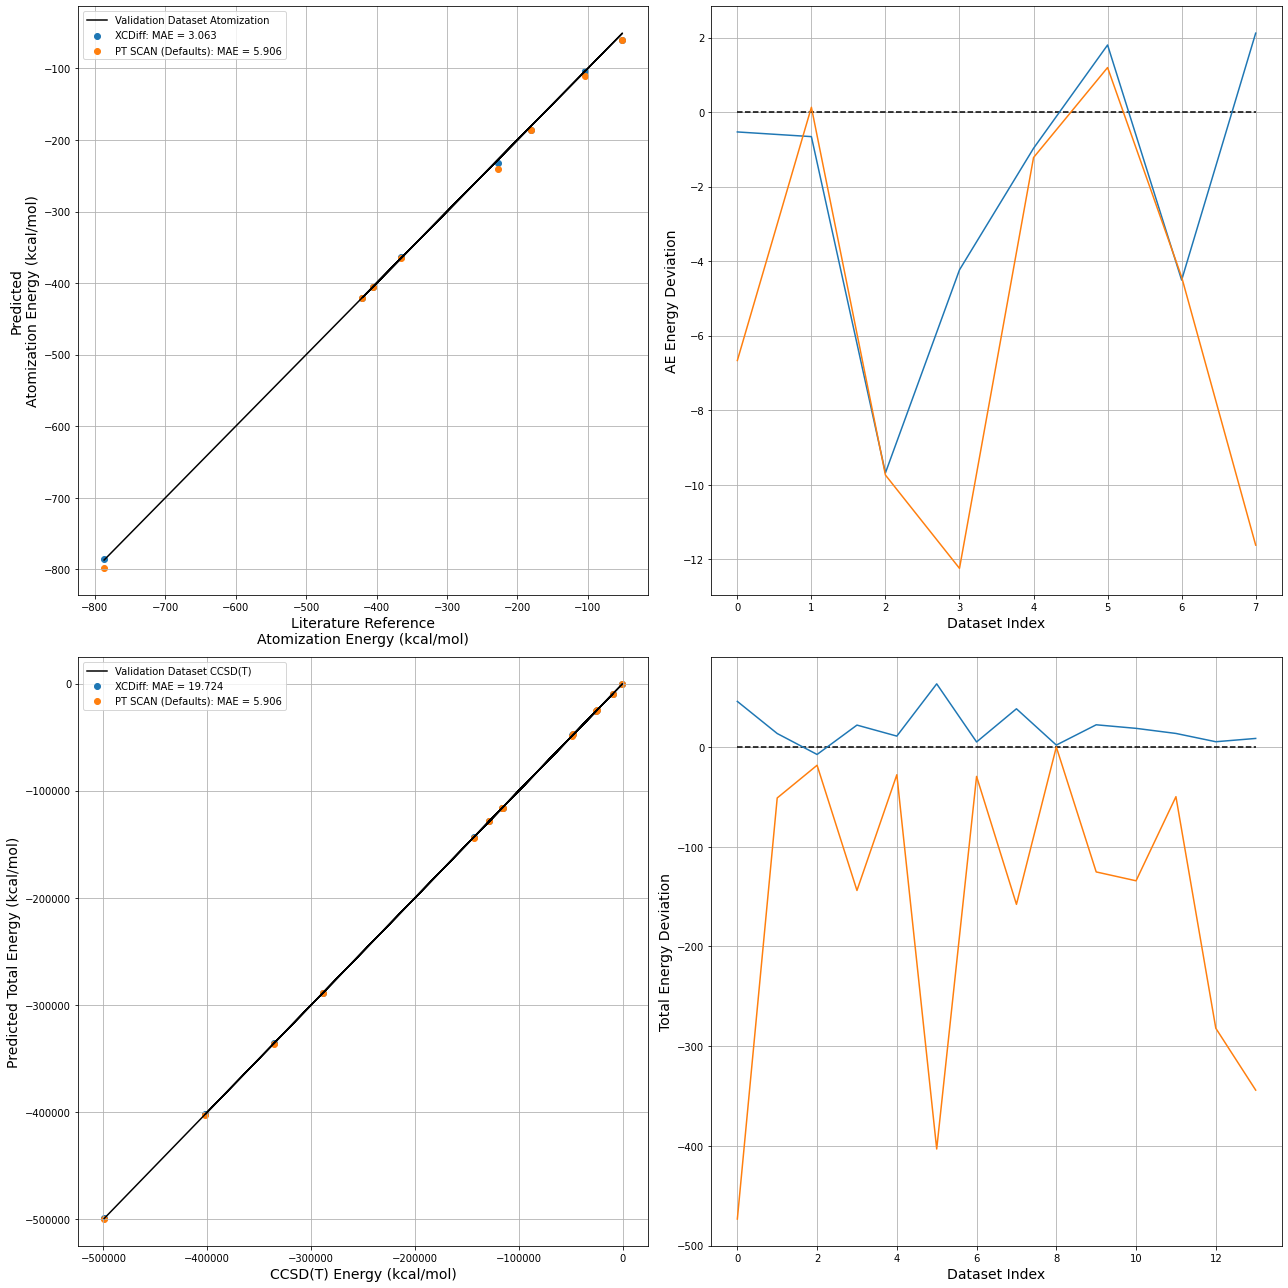

In [4]:
scale=Hart_to_kcalmol
refs = read('../data/validation/val_c.traj', ':')
ref_aes = [-at.info['atomization']*scale for at in refs[:8]]
ref_bhs = [at.info['bh_ref']*scale for at in refs[8:] if at.info.get('bh_ref', None)]
ordes = [at.info['energy']*scale for at in refs]
sinds = []
sref_aes = [i[1] for i in enumerate(ref_aes) if i[0] not in sinds]
sordes = [i[1] for i in enumerate(ordes) if i[0] not in sinds]
mae=True

xcdt = read_eval_table_only('../xcd/val/table.dat')
deft = read_eval_table_only('../01/MODEL_MGGA_e09/table.dat')
bhinds = [[8,9,10], [11,12,13]]
g2inds = [0,1,2,3,4,5,6,7]

tab=xcdt
xcdaey = scale*(tab.iloc[g2inds, 6].astype(np.float64))
xcdaeerr = scale*(tab.iloc[g2inds, 6].astype(np.float64) - tab.iloc[g2inds, 7].astype(np.float64))
xcdaee = np.mean(np.abs(xcdaeerr))
xcdey = scale*(tab.iloc[:, 2].astype(np.float64))
xcdeerr = scale*(tab.iloc[:, 2].astype(np.float64) - tab.iloc[:, 3].astype(np.float64))
xcdee = np.mean(np.abs(xcdeerr))

tab=deft
defaey = scale*(tab.iloc[g2inds, 6].astype(np.float64))
defaeerr = scale*(tab.iloc[g2inds, 6].astype(np.float64) - tab.iloc[g2inds, 7].astype(np.float64))
defaee = np.mean(np.abs(defaeerr))
defey = scale*(tab.iloc[:, 2].astype(np.float64))
defeerr = scale*(tab.iloc[:, 2].astype(np.float64) - tab.iloc[:, 3].astype(np.float64))
defee = np.mean(np.abs(defaeerr))
f, eax, edax, dax, ddax = gen_pltaxs(scale=scale)
if mae:
    cstr = 'MAE = '
else:
    cstr = '$\sqrt{MSE} = $'
ae_args = [
    (xcdaey, 'XCDiff: '+cstr+"{:4.3f}".format(xcdaee)),
    (defaey, 'PT SCAN (Defaults): '+cstr+'{:4.3f}'.format(defaee)),
]
e_args = [
    (xcdey, 'XCDiff: '+cstr+"{:4.3f}".format(xcdee)),
    (defey, 'PT SCAN (Defaults): '+cstr+'{:4.3f}'.format(defee)),
]
plot_e_dev(enax=eax, endax=edax, refs=np.array(ref_aes), reflabel='Validation Dataset Atomization', datlist=ae_args)
plot_e_dev(enax=dax, endax=ddax, refs=np.array(ordes), reflabel='Validation Dataset CCSD(T)', datlist=e_args)
eax.legend()
#edax.legend()
dax.legend()
#ddax.legend()
if scale == Hart_to_kcalmol:
    units = 'kcal/mol'
else:
    units = 'H'
plt.tight_layout()
#plt.savefig(os.path.join(figp, 'checks_currval_{}.png'.format(units.split('/')[0])), dpi=800)

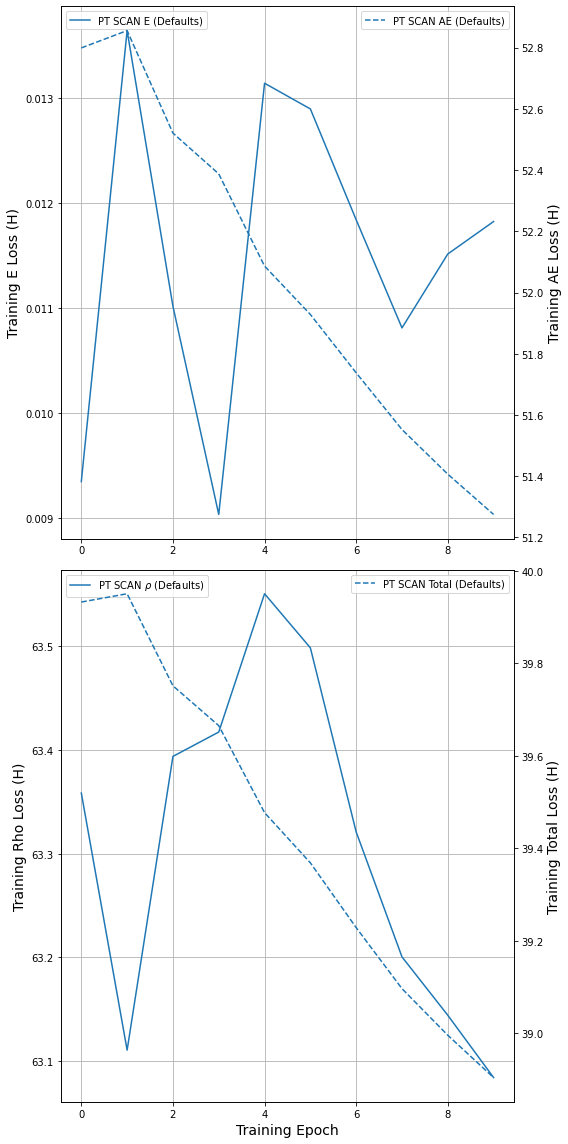

In [10]:
#default training losses
defloss = pd.read_csv('../01/train/2022-10-07_09:54:23.729086_totallosses.dat',
                     delimiter='\t', index_col=False, header=None, skiprows=1)
defloss.columns = ['Epoch', 'E', 'rho', 'ae', 'total']

f = plt.figure(figsize=(8,16))
ax = f.add_subplot(211)
tax = ax.twinx()
bax = f.add_subplot(212)
tbax = bax.twinx()

ax.plot(defloss['Epoch'], defloss['E'], label='PT SCAN E (Defaults)')
tax.plot(defloss['Epoch'], defloss['ae'], '--', label='PT SCAN AE (Defaults)')
bax.plot(defloss['Epoch'], defloss['rho'], label='PT SCAN $\\rho$ (Defaults)')
tbax.plot(defloss['Epoch'], defloss['total'], '--', label='PT SCAN Total (Defaults)')


ax.legend(loc='upper left')
tax.legend(loc='upper right')
bax.legend(loc='upper left')
tbax.legend(loc='upper right')
tax.set_ylabel('Training AE Loss (H)', fontsize=14)
ax.set_ylabel('Training E Loss (H)', fontsize=14)
bax.set_ylabel('Training Rho Loss (H)', fontsize=14)
tbax.set_ylabel('Training Total Loss (H)', fontsize=14)
ax.grid()
bax.grid()
bax.set_xlabel('Training Epoch', fontsize=14)
plt.tight_layout()

### Epoch 0 is an evaluation of the network on the training set, before updating during subsequent epochs.

[0.020921642955300968, 0.00034345609503816377]
0 0.020921642955300968
plotting ref bh: 0.0,0,17.7
1 0.00034345609503816377
plotting ref bh: 1.0,1,9.9
[0.01554255417070749, -0.002694427016535883]
0 0.01554255417070749
1 -0.002694427016535883


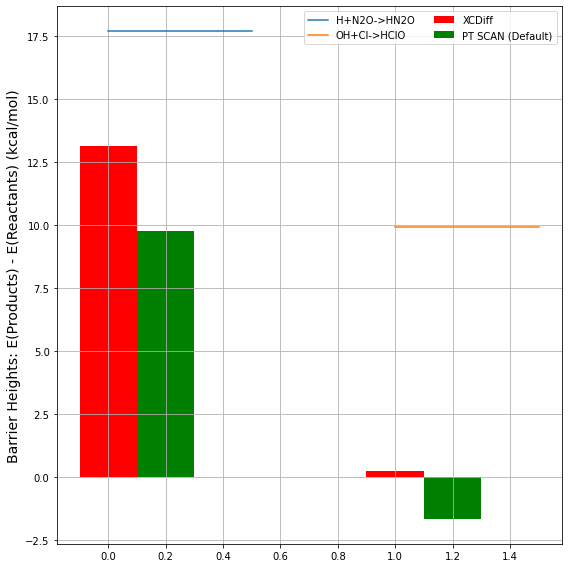

In [7]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)

xcdbhv = bhcalc(xcdt, bhinds, reftraj=refs)
defbhv = bhcalc(deft, bhinds, reftraj=refs)

bhys = [xcdbhv, defbhv]
labs = ['XCDiff', 'PT SCAN (Default)']
nxs = np.arange(len(xcdbhv))
nbhs = np.arange(len(bhys))
cs = ['r','g','b']
bhlabs = ['H+N2O->HN2O', 'OH+Cl->HClO']
for yidx, yp in enumerate(bhys):
    lab = labs[yidx]
    print(yp)
    for idx, y in enumerate(yp):
        print(idx, y)
        w=0.2
        shift = yidx*w
        y=y*scale
        if idx == 0:
#            ax.bar(idx+shift, abs(y-ref_bhs[idx]), label=lab, facecolor=cs[yidx], width=w)
            ax.bar(idx+shift, y, label=lab, facecolor=cs[yidx], width=w)
        else:
#            ax.bar(idx+shift, abs(y-ref_bhs[idx]), facecolor=cs[yidx], width=w)
            ax.bar(idx+shift, y, facecolor=cs[yidx], width=w)
        if yidx == 0:
            #pass
            print("plotting ref bh: {},{},{}".format(idx+shift,idx,ref_bhs[idx]))
            ax.plot([idx+shift, idx+0.5], [ref_bhs[idx], ref_bhs[idx]], label=bhlabs[idx])

ax.legend(ncol=2)
ax.grid()
ax.set_ylabel('Barrier Heights: E(Products) - E(Reactants) (kcal/mol)', fontsize=14)
plt.tight_layout()

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


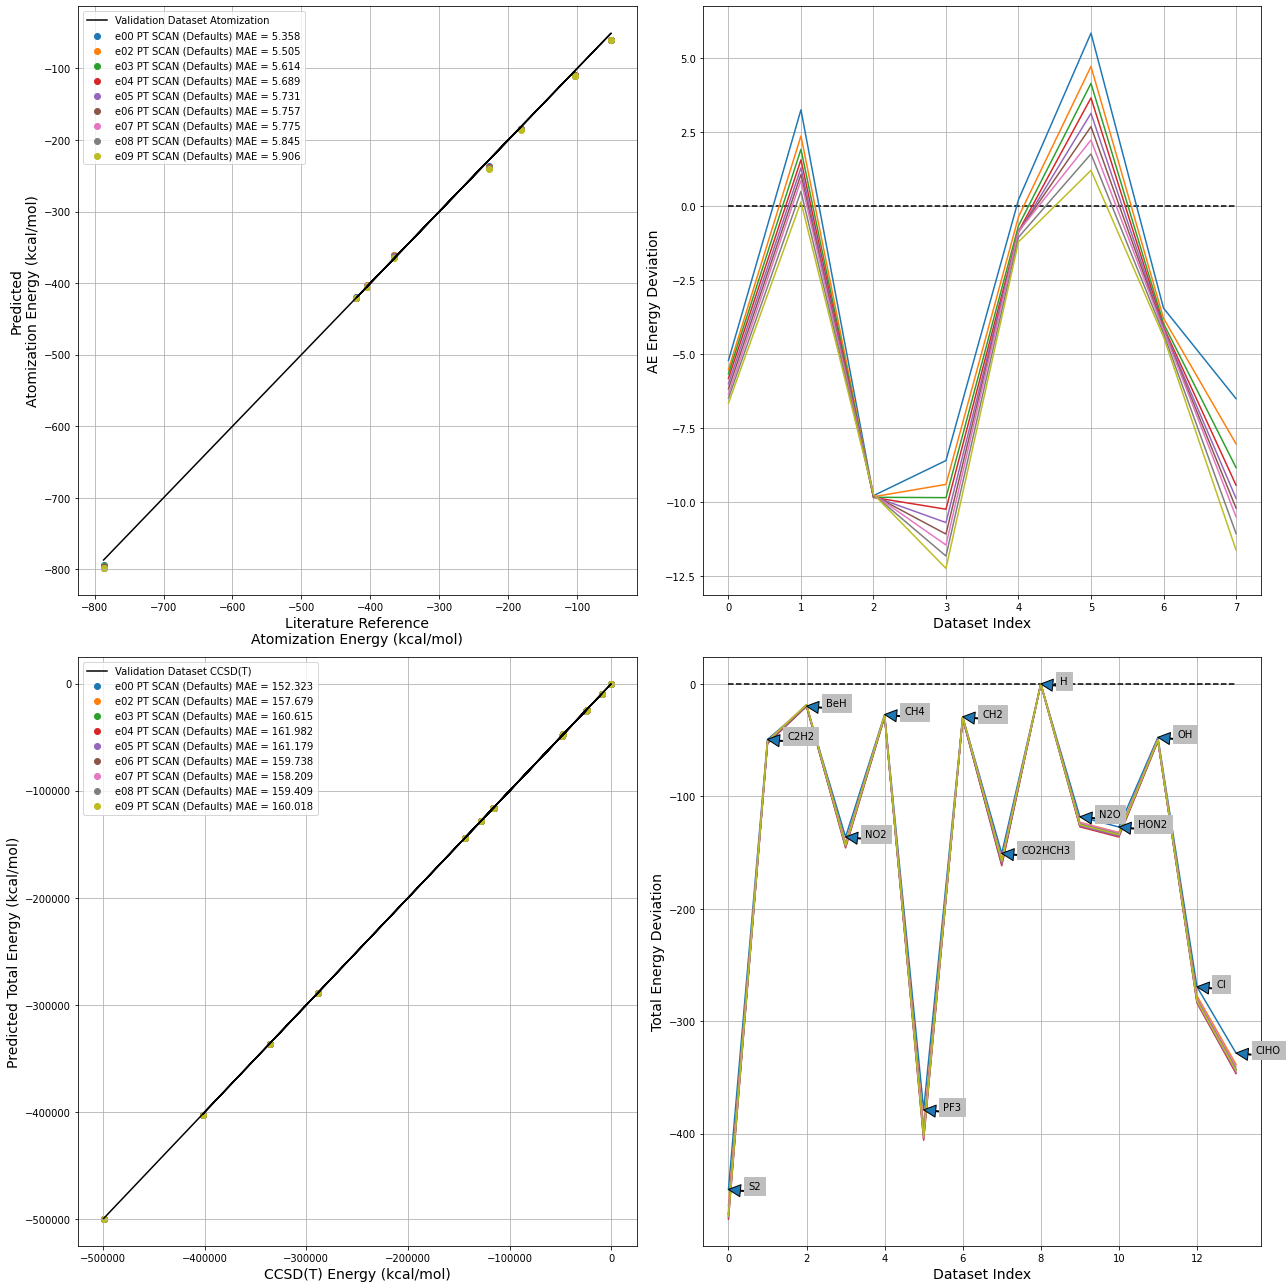

In [9]:
scale=Hart_to_kcalmol
refs = read('../data/validation/val_c.traj', ':')
ref_aes = [-at.info['atomization']*scale for at in refs[:8]]
ordes = [at.info['energy']*scale for at in refs]
sinds = []
sref_aes = [i[1] for i in enumerate(ref_aes) if i[0] not in sinds]
sordes = [i[1] for i in enumerate(ordes) if i[0] not in sinds]
mae=True
defp = '../01/'
dsubs = sorted([i for i in os.listdir(defp) if 'MODEL_MGGA' in i])
bhinds = [[8,9,10], [11,12,13]]
g2inds = [0,1,2,3,4,5,6,7]
f, eax, edax, dax, ddax = gen_pltaxs(scale=scale)
ae_args = []
e_args = []
for p in dsubs:
    epoch = p.split('_')[-1]
    tp = os.path.join(defp, p, 'table.dat')
    tab = read_eval_table_only(path=tp)
    
    defaey = scale*(tab.iloc[g2inds, 6].astype(np.float64))
    defaeerr = scale*(tab.iloc[g2inds, 6].astype(np.float64) - tab.iloc[g2inds, 7].astype(np.float64))
    defaee = np.mean(np.abs(defaeerr))
    defey = scale*(tab.iloc[:, 2].astype(np.float64))
    defeerr = scale*(tab.iloc[:, 2].astype(np.float64) - tab.iloc[:, 3].astype(np.float64))
    defee = np.mean(np.abs(defeerr))
    ae_args.append((defaey, epoch+' PT SCAN (Defaults) '+cstr+"{:4.3f}".format(defaee)))
    e_args.append((defey, epoch+' PT SCAN (Defaults) '+cstr+"{:4.3f}".format(defee)))

        
plot_e_dev(enax=eax, endax=edax, refs=np.array(ref_aes), reflabel='Validation Dataset Atomization', datlist=ae_args)
plot_e_dev(enax=dax, endax=ddax, refs=np.array(ordes), reflabel='Validation Dataset CCSD(T)', datlist=e_args)
if mae:
    cstr = 'MAE = '
else:
    cstr = '$\sqrt{MSE} = $'
eax.legend()
#edax.legend()
dax.legend()
#ddax.legend()
if scale == Hart_to_kcalmol:
    units = 'kcal/mol'
else:
    units = 'H'
    
for idx, at in enumerate(refs):
    ddax.annotate(at.symbols, (idx, e_args[0][0].values[idx]-ordes[idx]), (idx+0.5, e_args[0][0].values[idx]-ordes[idx]),
                    backgroundcolor="#bebebe", alpha=1, arrowprops={'width':1})
    
plt.tight_layout()
#plt.savefig(os.path.join(figp, 'checks_defaultval_{}.png'.format(units.split('/')[0])), dpi=800)